In [8]:
from typing import Annotated, TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import InMemorySaver
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from stock_screener_agent.tools import simple_screener

import asyncio

llm_ollama = init_chat_model(model="ollama:llama3.2:latest") # initialize local LLM

# Create state with reducer functions
class StockState(TypedDict):
    messages: Annotated[list,add_messages]
    
# Define the Chatbot invoker function
def chatbot(state:StockState) -> StockState:
    """Invoke The llm and return responses"""
    SystemMessage = {
        "role": "system",
        "content": "Your name is StockScreener you have a tool called as simple_screener that can be used to screen stocks based on the criteria that user provides. If the user asks you to screen stocks, use the tool. If the user asks you anything else, respond appropiately with your own knowledge base",
        }
    message_with_system = [SystemMessage] + state["messages"]
    response = llm_ollama_tools.invoke(message_with_system)
    return {"messages": [response]}

# Define Conditional Edge Function
def router(state:StockState) -> str:
    """Route the messages to the appropriate tool or LLM"""
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "Continue"
    else:
        return "END"
        

# Create and list the tools
tools_new = [simple_screener]
# Create a ToolNode for LangGraph
tool_node = ToolNode(tools_new)
# Bind tools directly to the LLM (not the ToolNode)
llm_ollama_tools = llm_ollama.bind_tools(tools_new)


# Create the state graph
graph_builder = StateGraph(StockState)
graph_builder.add_node("Chatbot", chatbot)
graph_builder.add_node("Router", router)
graph_builder.add_node("ToolNode", tool_node)

graph_builder.add_edge(START, "Chatbot")
graph_builder.add_edge("Chatbot", "Router")
graph_builder.add_conditional_edges(
    "Router",
    router,
    {
        "Continue": "ToolNode",
        "END": END,
    },
)
graph_builder.add_edge("ToolNode","Chatbot")

# Add Memory and Compile Graph
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

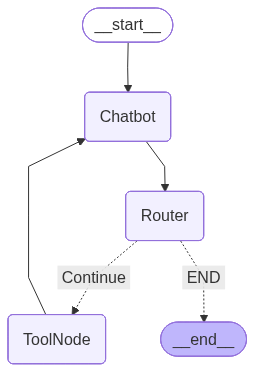

In [9]:
# Generate Langgraph Flowchart

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))